# CitiBike Trip Distance Comparison: Young vs. Old

### Null Hypothesis $H_0$:
Young adults (ages 18-35) on average ride citi bikes equal or *smaller distances per trip* than adults of other age groups.

### Alternative Hypothesis $H_a$:
Young adults (ages 18-35) on average ride farther distances per trip than adults of other age groups.

#### Testing Strategy:
For this analysis, I will use a Z test with an $\alpha$/__significance level__ of __0.05__ ($\alpha: 0.05$)


In [60]:
from __future__ import print_function
import os
from scipy import stats

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!curl -O "https://s3.amazonaws.com/tripdata/201801-citibike-tripdata.csv.zip"
!unzip -u '*.zip' -d $PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.1M  100 22.1M    0     0  63.2M      0 --:--:-- --:--:-- --:--:-- 63.3M
Archive:  201809-citibike-tripdata.csv.zip

Archive:  201807-citibike-tripdata.csv.zip

Archive:  201801-citibike-tripdata.csv.zip

3 archives were successfully processed.


In [6]:
PUIDATA = os.getenv("PUIDATA")
df = pd.read_csv(PUIDATA+'/201801-citibike-tripdata.csv', low_memory=False)

In [7]:
df.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1


In [8]:
# I'm calculating distance to test my hypothesis
def CalcDist(lon1, lat1, lon2, lat2):
    '''
    Will Use this to calculate distance (straight line) from start to stop
    '''
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon=lon2-lon1
    dlat=lat2-lat1
    
    '''This is the distance formula'''
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df['Distance'] = \
    CalcDist(df['start station longitude'], df['start station latitude'], df['end station longitude'], df['end station latitude'])
    

In [9]:
#Also need to add an 'Age' column
df['Age'] = (2018 - df['birth year']).astype(int)

df_reducted = df[['Age','Distance']]
df_reducted.head(3)

,Age,Distance
0,26,2.080202
1,49,1.855415
2,62,1.435362


In [97]:
# Create a subset of the data for 'young people' aged 18 to 30
youngpeople = df_reducted[(df_reducted['Age']>18)&(df_reducted['Age']<35)]
youngpeople.head(3)

,Age,Distance
0,26,2.080202
4,26,1.130394
13,27,1.030388


In [99]:
# create a subset for 'old people'
oldpeople = df_reducted[df_reducted['Age']>=35]
oldpeople.head()

,Age,Distance
1,49,1.855415
2,62,1.435362
3,44,0.837513
5,50,3.135244
6,40,2.329651


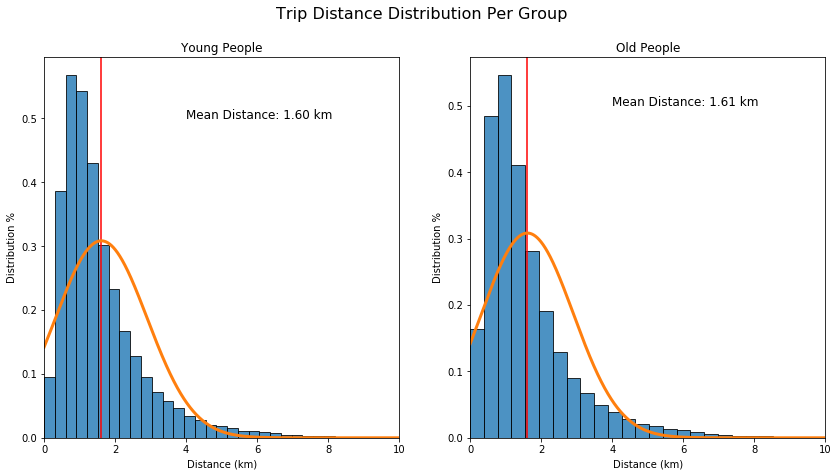

In [105]:
oldsorted = oldpeople.sort_values('Distance')
youngsorted = youngpeople.sort_values('Distance')

mu1, sigma1 = scipy.stats.norm.fit(oldsorted.Distance)
curve1 = scipy.stats.norm.pdf(oldsorted.Distance, mu1, sigma1)

mu2, sigma2 = scipy.stats.norm.fit(youngsorted.Distance)
curve2 = scipy.stats.norm.pdf(youngsorted.Distance, mu1, sigma1)

fig = plt.figure(figsize=(14,7))
ax2 = fig.add_subplot(121)
ax = fig.add_subplot(122)

fig.suptitle('Trip Distance Distribution Per Group', fontsize=16)

ax.hist(oldsorted.Distance,bins=40, density=True, edgecolor='black', alpha=0.8)
ax.axvline(x=oldsorted.Distance.mean(),color='r')
ax.text(4,0.5,'Mean Distance: {:.2f} km'.format(oldsorted.Distance.mean()), fontsize=12)
ax.set_xlim(0,10)
ax.set_title('Old People', fontsize=12)
ax.plot(oldsorted.Distance,curve1,lw=3)

ax2.hist(youngsorted.Distance,bins=40, density=True, edgecolor='black', alpha=0.8)
ax2.axvline(x=youngsorted.Distance.mean(),color='r')
ax2.text(4,0.5,'Mean Distance: {:.2f} km'.format(youngsorted.Distance.mean()), fontsize=12)
ax2.set_xlim(0,10)
ax2.set_title('Young People', fontsize=12)
ax2.plot(youngsorted.Distance,curve2,lw=3)

ax.set_ylabel('Distribution %')
ax2.set_ylabel('Distribution %')
ax.set_xlabel('Distance (km)')
ax2.set_xlabel('Distance (km)')

fig.savefig('TripDistance.png')
# plt.tight_layout()

__Figure 1:__ The graphs show that the young and old groups have a similar mean distance. Both groups also follow close to a normal distribution, though they are positively skewed since we cannot have negative values. 

### Notes:
* The formula used for distance is not perfect because it is straight line. It would be better to calculate an actual biking distance using Google's API but you'd reach the API limit looping over all of the records in this dataset

## Statistical Testing: Welch's t Test (for 2 sample means), variance and size unequal

Because we are testing the means of two sample groups, we will perform a unpaired T Test. Our two dataframes have different variances and different sizes so we will use a Welch's t test; source: https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test

FORMULA: $t = \frac{x_1-x_2}{\sqrt{(s_1^2/n_1+s_2^2/n_2}}$

In [101]:
# self defined t test for unequal sample sizes, unequal variances
def t_Score(young,old):
    x1, std1, n1 = young.mean(),young.std(),len(young)
    x2, std2, n2 = old.mean(),old.std(),len(old)
    stat = (x1-x2)/np.sqrt(std1**2/n1 + std2**2/n2)
    df = (std1**2/n1 + std2**2/n2)**2/((std1**4/(n1**2*(n1-1))) + (std2**4/(n2**2*(n2-1))))
    return('Statistic: {}, Degrees of Freedom: {}'.format(stat,df))
t_Score(oldsorted.Distance,youngsorted.Distance)    

'Statistic: 5.109309779616752, Degrees of Freedom: 625539.199955736'

In [102]:
# matches scipy stats
scipy.stats.ttest_ind(oldsorted.Distance,youngsorted.Distance,equal_var=False)

Ttest_indResult(statistic=5.1093097796167513, pvalue=3.2343256041548496e-07)

## Results

Consulting a t-test with a t-stat of 5.11 and an $\alpha$ of 0.05, you would fail to reject the null if you had only 1 degree of freedom. However, our degrees of freedom is found using the Welch-Satterthwaite Equation and is extremely high, and you can reject the null at decreasing t stat levels as df increases. In addition, by running the independent ttest through scipy.stats, we get a p value of 0.00000. Our two groups are therefore **significantly different**. 

However, our null hypothesis states that young people have smaller than or equal trip distances to old people. By just looking at the means of each trip distance, we can see that old people in fact travel longer distances. We therefore **fail to reject the null**